#### <i> AI-Driven Sentiment Analysis for Bitcoin Market Trends A Predictive Approach to Crypto Volatility 25307 </i>
#### <i> Import Library Files </i>

In [135]:
# 📦 Step 1: Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')



#### <i> Load The Dataset </i>

In [136]:
df_1 = pd.read_csv("Bitcoin-price-USD.csv")
df_1

,Date,Price
0,2010-07-18,0.090000
1,2010-07-19,0.080000
2,2010-07-20,0.070000
3,2010-07-21,0.080000
4,2010-07-22,0.050000
...,...,...
5134,2024-08-07,55027.460938
5135,2024-08-08,61710.136719
5136,2024-08-09,60880.113281
5137,2024-08-10,60945.812500


In [137]:
df = pd.read_csv("bitcoin_tweets.csv")
df

,id,user,fullname,url,timestamp,replies,likes,retweets,text
0,1.132977e+18,KamdemAbdiel,Abdiel kamdem,NaN,2019-05-27 11:49:14+00,0.0,0.0,0.0,È appena uscito un nuovo video! LES CRYPTOMONN...
1,1.132977e+18,bitcointe,Bitcointe,NaN,2019-05-27 11:49:18+00,0.0,0.0,0.0,Cardano: Digitize Currencies; EOS https://t.co...
2,1.132977e+18,3eyedbran,Bran - 3 Eyed Raven,NaN,2019-05-27 11:49:06+00,0.0,2.0,1.0,Another Test tweet that wasn't caught in the s...
3,1.132977e+18,DetroitCrypto,J. Scardina,NaN,2019-05-27 11:49:22+00,0.0,0.0,0.0,Current Crypto Prices! \n\nBTC: $8721.99 USD\n...
4,1.132977e+18,mmursaleen72,Muhammad Mursaleen,NaN,2019-05-27 11:49:23+00,0.0,0.0,0.0,Spiv (Nosar Baz): BITCOIN Is An Asset &amp; NO...
...,...,...,...,...,...,...,...,...,...
99996,1.127210e+18,ChrisKnight407,💎🛸Chris Knight🖤🐺,NaN,2019-05-11 11:52:58+00,0.0,0.0,1.0,😂😂😂 facts #bitcoin https://t.co/mmI634HtKc
99997,1.127210e+18,webmastep,⚡️⚡️⚡️ Oleg ⚡️⚡️⚡️,NaN,2019-05-11 11:53:37+00,0.0,0.0,0.0,"BitcoinLend Airdropping 1,000,000 BLEND ($1,00..."
99998,1.127210e+18,filip_olevski,filip_olevski,NaN,2019-05-11 11:53:58+00,0.0,0.0,0.0,#inzura #tokensale\nNow is good time to get ri...
99999,1.127210e+18,Scot_Striker,Scott Striker,NaN,2019-05-11 11:54:15+00,0.0,0.0,0.0,"XRP, Bitcoin and other coins to be made availa..."


In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100001 entries, 0 to 100000
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         100001 non-null  float64
 1   user       100001 non-null  object 
 2   fullname   99998 non-null   object 
 3   url        3322 non-null    object 
 4   timestamp  100001 non-null  object 
 5   replies    100001 non-null  float64
 6   likes      100001 non-null  float64
 7   retweets   100001 non-null  float64
 8   text       100001 non-null  object 
dtypes: float64(4), object(5)
memory usage: 6.9+ MB


In [139]:
df.describe()

,id,replies,likes,retweets
count,1.000010e+05,100001.000000,100001.000000,100001.000000
mean,1.124750e+18,0.835622,7.209348,2.717283
std,1.964566e+16,14.136570,95.277802,46.673868
min,1.110303e+09,0.000000,0.000000,0.000000
25%,1.126890e+18,0.000000,0.000000,0.000000
50%,1.126998e+18,0.000000,0.000000,0.000000
75%,1.127116e+18,0.000000,0.000000,0.000000
max,1.132985e+18,2104.000000,14470.000000,7816.000000


#### <i> Data Preprocessing </i>

In [140]:
# 🧹 Step 3: Data Cleaning
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.drop(columns=['id', 'url', 'fullname'], inplace=True)

In [141]:
# Fill missing values if any
df.fillna('', inplace=True)

# Text cleaning function
def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|#\w+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    return text

df['clean_text'] = df['text'].apply(clean_text)

In [142]:
# 📊 Step 4: Feature Engineering
# Engagement score (can be tweaked)
df['engagement'] = df['likes'] + (2 * df['retweets']) + (0.5 * df['replies'])

# 📈 Step 5: Sentiment Labeling using VADER
sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = sid.polarity_scores(text)
    compound = score['compound']
    if compound >= 0.05:
        return 'positive'
    elif compound <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df['clean_text'].apply(get_sentiment)


#### <i> Expolatory Data Analysis </i>

In [143]:
#  EDA (WordClouds)
text_pos = ' '.join(df[df['sentiment'] == 'positive']['clean_text'])
text_neg = ' '.join(df[df['sentiment'] == 'negative']['clean_text'])
text_neu = ' '.join(df[df['sentiment'] == 'neutral']['clean_text'])

wordcloud_pos = WordCloud(width=600, height=400, background_color='white').generate(text_pos)
wordcloud_neg = WordCloud(width=600, height=400, background_color='black', colormap='Reds').generate(text_neg)
wordcloud_neu = WordCloud(width=600, height=400, background_color='gray').generate(text_neu)



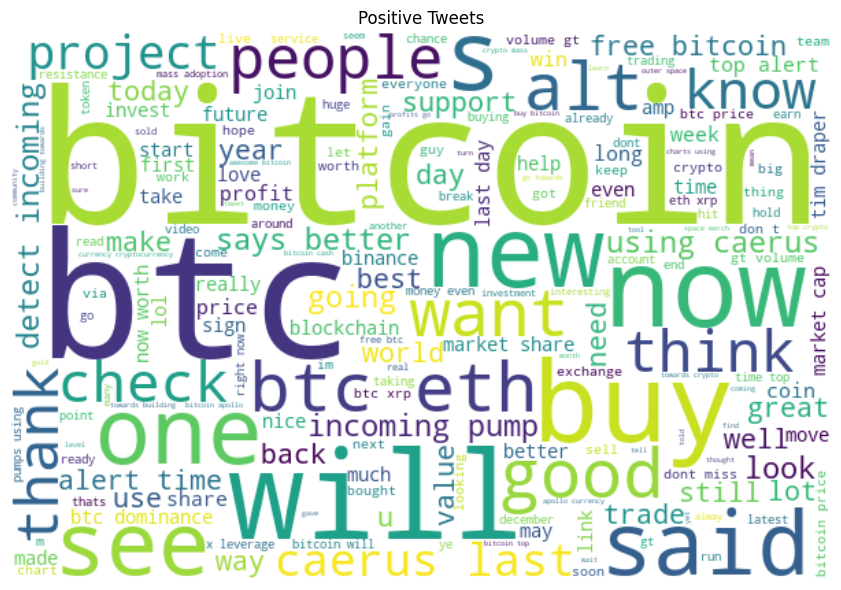

In [144]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title("Positive Tweets")
plt.axis('off')

plt.tight_layout()
plt.show()

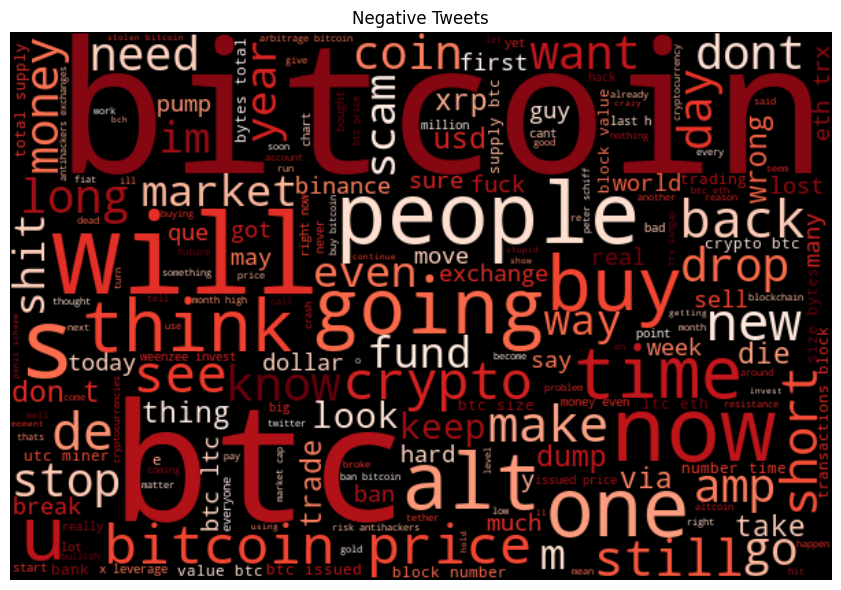

In [145]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.title("Negative Tweets")
plt.axis('off')

plt.tight_layout()
plt.show()


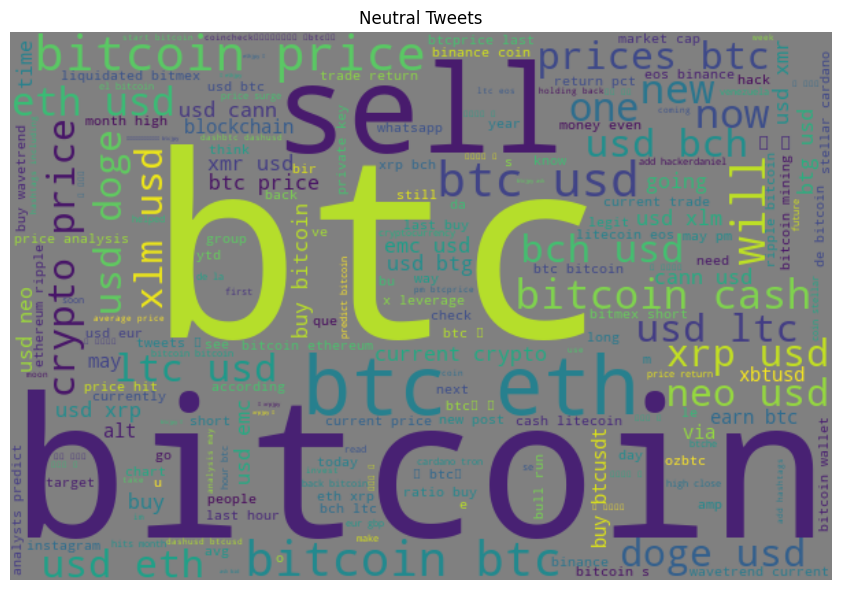

In [146]:
plt.figure(figsize=(12,6))
plt.imshow(wordcloud_neu, interpolation='bilinear')
plt.title("Neutral Tweets")
plt.axis('off')

plt.tight_layout()
plt.show()

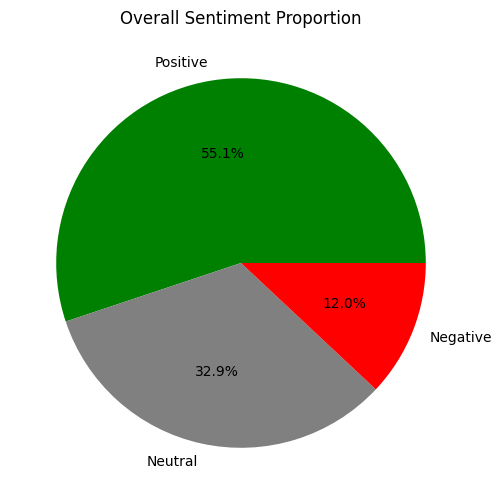

In [147]:
# Sentiment proportion pie chart
plt.figure(figsize=(6, 6))
df['sentiment'].value_counts().plot.pie(autopct='%1.1f%%', colors=['green', 'gray', 'red'], labels=['Positive', 'Neutral', 'Negative'])
plt.title("Overall Sentiment Proportion")
plt.ylabel("")
plt.show()


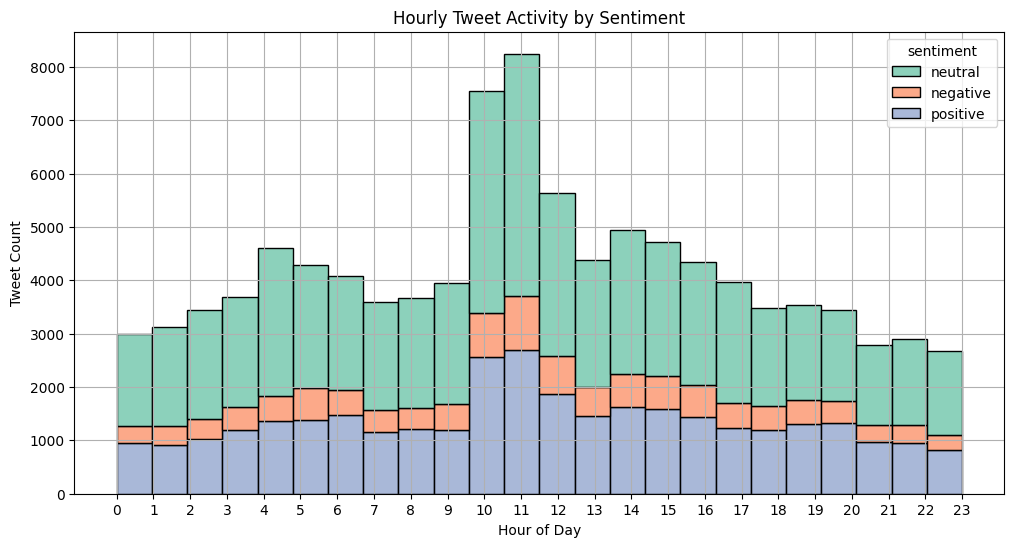

In [148]:
# Extract hour
df['hour'] = df['timestamp'].dt.hour

# Hourly tweet count by sentiment
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='hour', hue='sentiment', multiple='stack', bins=24, palette='Set2')
plt.title("Hourly Tweet Activity by Sentiment")
plt.xlabel("Hour of Day")
plt.ylabel("Tweet Count")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


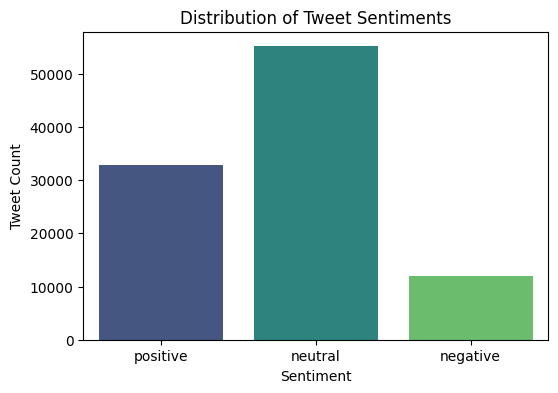

In [149]:
# Sentiment distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='sentiment', order=['positive', 'neutral', 'negative'], palette='viridis')
plt.title("Distribution of Tweet Sentiments")
plt.xlabel("Sentiment")
plt.ylabel("Tweet Count")
plt.show()

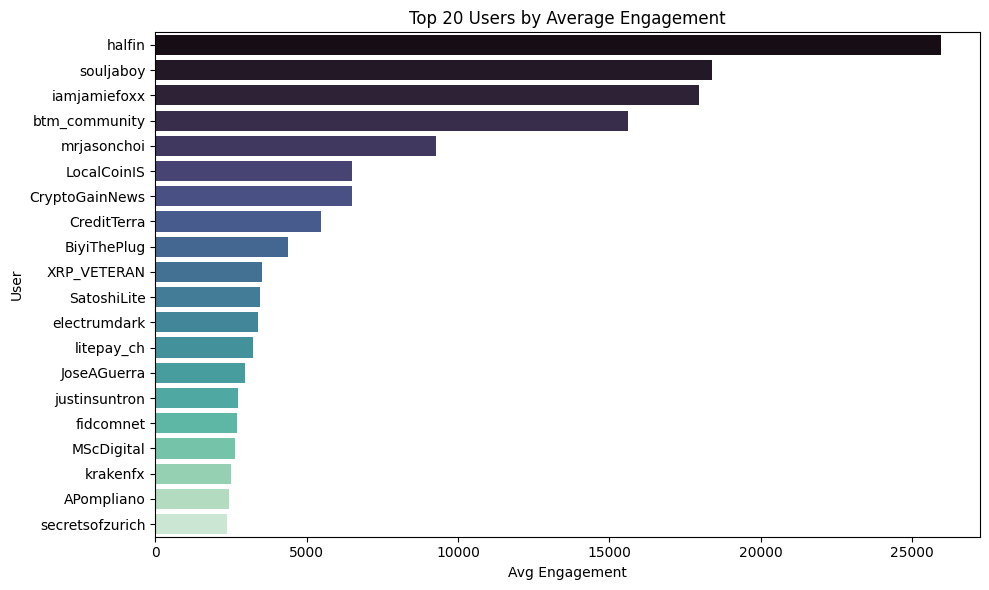

In [150]:
# Top users by average engagement
top_users = df.groupby('user')['engagement'].mean().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(y=top_users.index, x=top_users.values, palette='mako')
plt.title("Top 20 Users by Average Engagement")
plt.xlabel("Avg Engagement")
plt.ylabel("User")
plt.tight_layout()
plt.show()


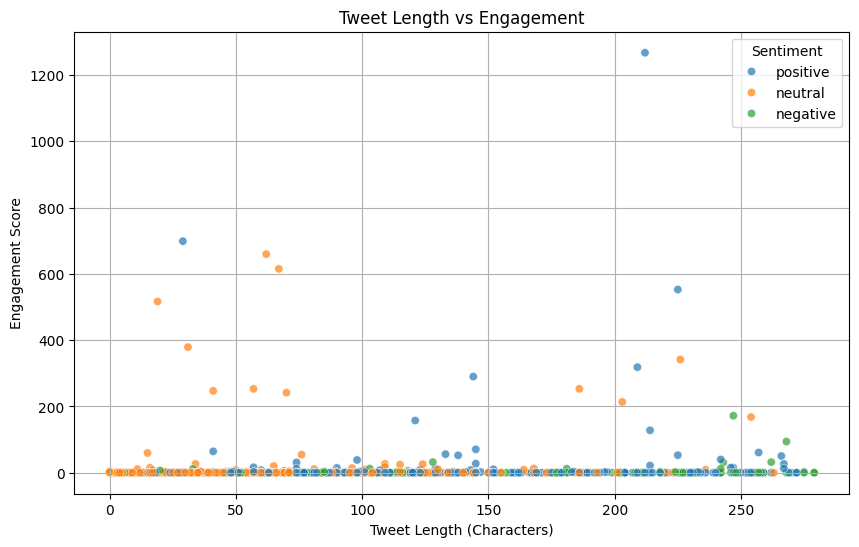

In [151]:
# Tweet length column
df['text_length'] = df['clean_text'].apply(len)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df.sample(1000, random_state=1), x='text_length', y='engagement', hue='sentiment', alpha=0.7)
plt.title("Tweet Length vs Engagement")
plt.xlabel("Tweet Length (Characters)")
plt.ylabel("Engagement Score")
plt.legend(title="Sentiment")
plt.grid(True)
plt.show()


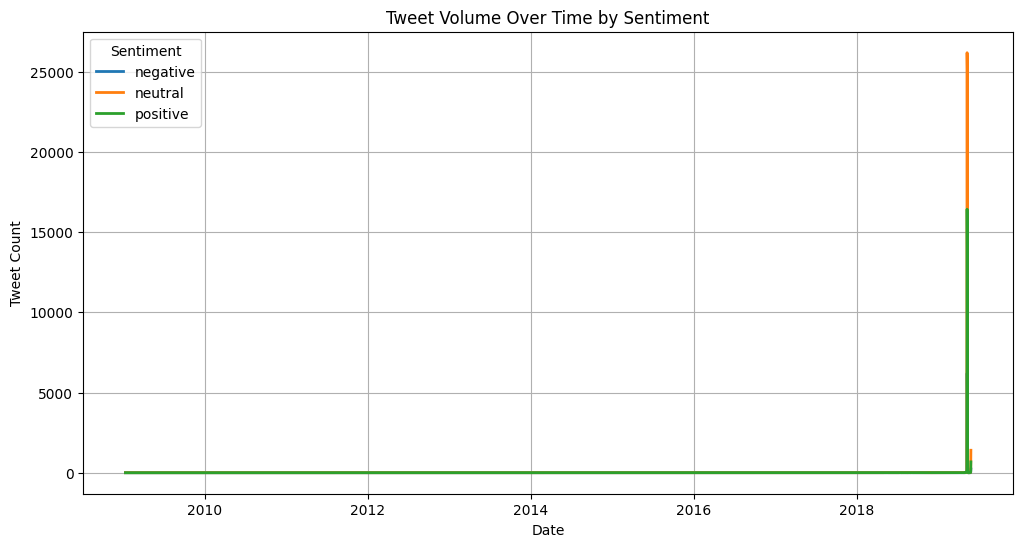

In [152]:
# Tweet volume over time
df['date'] = df['timestamp'].dt.date
tweet_volume = df.groupby(['date', 'sentiment']).size().unstack().fillna(0)

tweet_volume.plot(figsize=(12, 6), linewidth=2)
plt.title("Tweet Volume Over Time by Sentiment")
plt.xlabel("Date")
plt.ylabel("Tweet Count")
plt.legend(title="Sentiment")
plt.grid(True)
plt.show()


#### <i> Models </i>
#### <i> Logistic Regression </i>

In [153]:
# 🧠 Step 6: Model Training
# Encode sentiment labels
df['label'] = df['sentiment'].map({'positive': 1, 'neutral': 0, 'negative': -1})

# TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words=stopwords.words('english'))
X = tfidf.fit_transform(df['clean_text'])
y = df['label']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

          -1       0.86      0.64      0.73      2406
           0       0.92      0.98      0.95     10984
           1       0.92      0.91      0.92      6611

    accuracy                           0.92     20001
   macro avg       0.90      0.84      0.87     20001
weighted avg       0.92      0.92      0.91     20001

Accuracy: 0.9170541472926353


#### <i> Random Forest Classifier </i>

In [154]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))
print("Accuracy:", accuracy_score(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

          -1       0.92      0.52      0.67      2406
           0       0.92      0.97      0.95     10984
           1       0.87      0.93      0.90      6611

    accuracy                           0.90     20001
   macro avg       0.90      0.81      0.84     20001
weighted avg       0.90      0.90      0.90     20001

Accuracy: 0.904004799760012


#### <i> SVC </i>

In [155]:
from sklearn.svm import LinearSVC

# Support Vector Machine
svm = LinearSVC()
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("Support Vector Machine:")
print(classification_report(y_test, y_pred_svm))
print("Accuracy:", accuracy_score(y_test, y_pred_svm))

Support Vector Machine:
              precision    recall  f1-score   support

          -1       0.86      0.71      0.78      2406
           0       0.94      0.98      0.96     10984
           1       0.94      0.93      0.93      6611

    accuracy                           0.93     20001
   macro avg       0.91      0.87      0.89     20001
weighted avg       0.93      0.93      0.93     20001

Accuracy: 0.9317534123293836


#### <i> Confusion Matrix Of All Models </i>

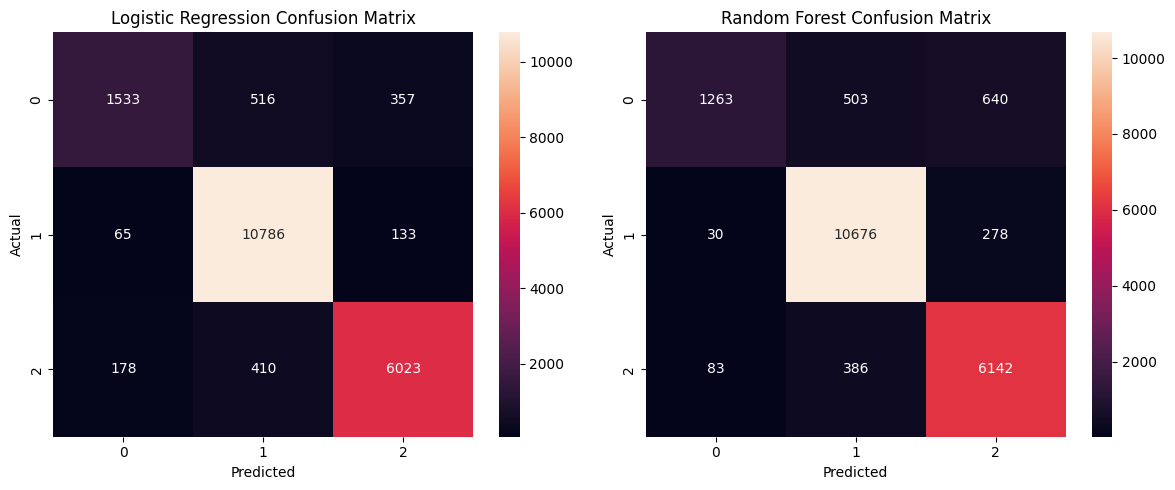

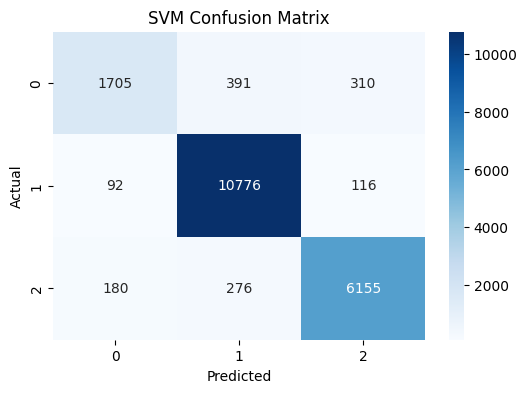

In [156]:
# Confusion Matrix for both models
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', ax=axs[0])
axs[0].set_title('Logistic Regression Confusion Matrix')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', ax=axs[1])
axs[1].set_title('Random Forest Confusion Matrix')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



#### <i> Model Comparisions </i>

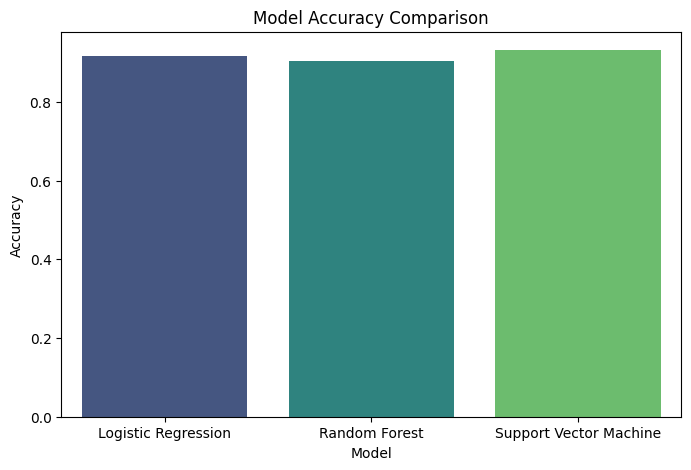

In [157]:
# Accuracy Comparison
accuracy_dict = {
    'Logistic Regression': accuracy_score(y_test, y_pred_lr),
    'Random Forest': accuracy_score(y_test, y_pred_rf),
    'Support Vector Machine': accuracy_score(y_test, y_pred_svm)
}

# Create a bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(accuracy_dict.keys()), y=list(accuracy_dict.values()), palette='viridis')
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.show()
